In [1]:
import os
import numpy as np
import glob
from tqdm import tqdm
import copy
from skimage.feature import canny
from skimage.transform import resize
import pandas as pd
import seaborn as sns
import nibabel as nib
import SimpleITK as sitk

# from torchinfo import summary

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchio as tio
import networks_gan
import losses
from skimage.metrics import structural_similarity as ssim
from dataloader import RadOncTrainingDataset, RadOncValidationDataset, RadOncSynthesisDataset, headscanner_training_dataset, headscanner_validation_dataset
import surface_distance
from helpers import compute_surface_metrics, compute_TRE
os.environ['VXM_BACKEND'] = 'pytorch'
import voxelmorph as vxm  # nopep8

import matplotlib.pyplot as plt
from matplotlib import colors as mplcolors
from matplotlib.collections import LineCollection
def colormap_binary(fg, bg=(0,0,0), alpha=None):
    fg = mplcolors.to_rgb(fg)
    bg = mplcolors.to_rgb(bg)
    cmap = mplcolors.LinearSegmentedColormap.from_list('Binary', (bg,fg), 256)
    if alpha is not None:
        cmap._init()
        cmap._lut[:,-1] = np.linspace(0, alpha, cmap.N+3)
    return cmap
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('dark_background')

2023-11-27 23:11:47.103491: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 23:11:47.270022: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 23:11:47.273578: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-27 23:11:47.273591: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [29]:
from helpers import normalizeImage
def thres_cbct(src, dst):
    n = nib.load(src)
    data = n.get_fdata()
    print(data.max(), data.min())
    data_thresholded = data
    data_thresholded[data_thresholded<-100] = -100
    data_thresholded[data_thresholded>100] = -100
    newdata = (data-(-100))/200
#     print(newdata)
    n_out = nib.Nifti1Image(newdata, n.affine, n.header)
    # n_out.header = n.header.copy()
    n_out.to_filename(dst)
    
def thres_mr(mr):
    m,M = np.percentile(mr,[1,99])
    data_thresholded = mr
    data_thresholded = np.clip((mr-m)/(M-m),0,1)
    return data_thresholded
# Read data
cbct_n = nib.load('inputs_clnc1/N040/CBCT_resample_crop.nii.gz')
cbct = cbct_n.get_fdata()
print(cbct.max(),cbct.min())
mr_n = nib.load('inputs_clnc1/N040/MR_resample_crop.nii.gz')
mr = mr_n.get_fdata()
print(mr.max(),mr.min())


CT_min = -100.0
CT_max = 100.0
CBCT_min = 100
CBCT_max = 300
T1_min = -100.0 ##?
T1_max = 1200.0 ## ?
# cbct = normalizeImage(cbct, CBCT_max, CBCT_min)
# # mr = normalizeImage(mr, T1_max, T1_min)
# # mr_gt = normalizeImage(mr_gt, 2300, T1_min)
# mr = thres_mr(mr)
# mr_gt = thres_mr(mr_gt)




17792.373046875 -10203.875
938.0 0.0


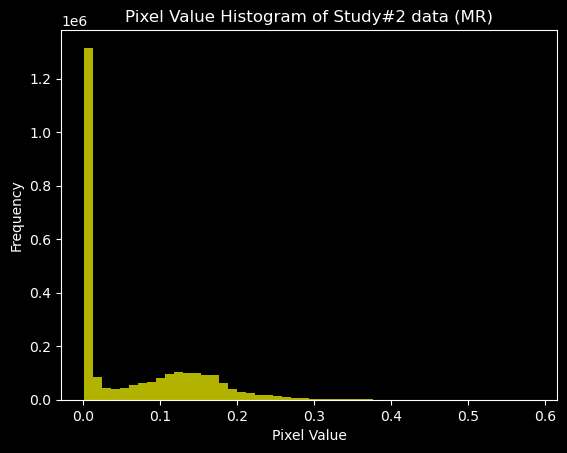

In [3]:
mr_i = np.interp(mr,[0,1600],[0,1])

pix_mr = mr_i.flatten()
pix_mr = pix_mr[pix_mr>0]

plt.hist(pix_mr, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Study#2 data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

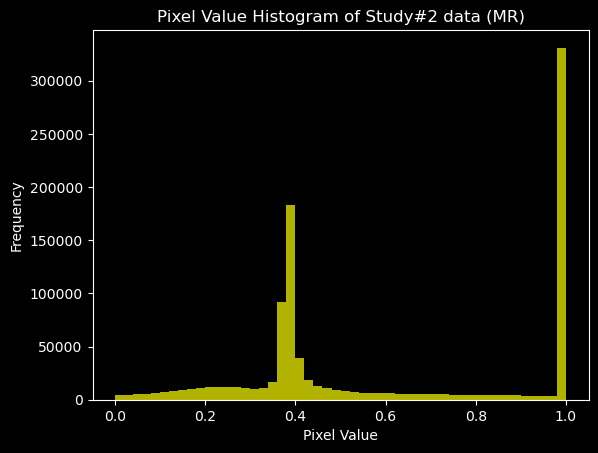

In [33]:
cbct_i = np.interp(cbct,[-200,400],[0,1])

pix_cbct = cbct_i.flatten()
pix_cbct = pix_cbct[pix_cbct>0]

plt.hist(pix_cbct, bins=50, color='yellow', alpha=0.7)
plt.title('Pixel Value Histogram of Study#2 data (MR)')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

In [12]:
cbct_i_can = np.interp(cbct,[-100,100],[0,1])

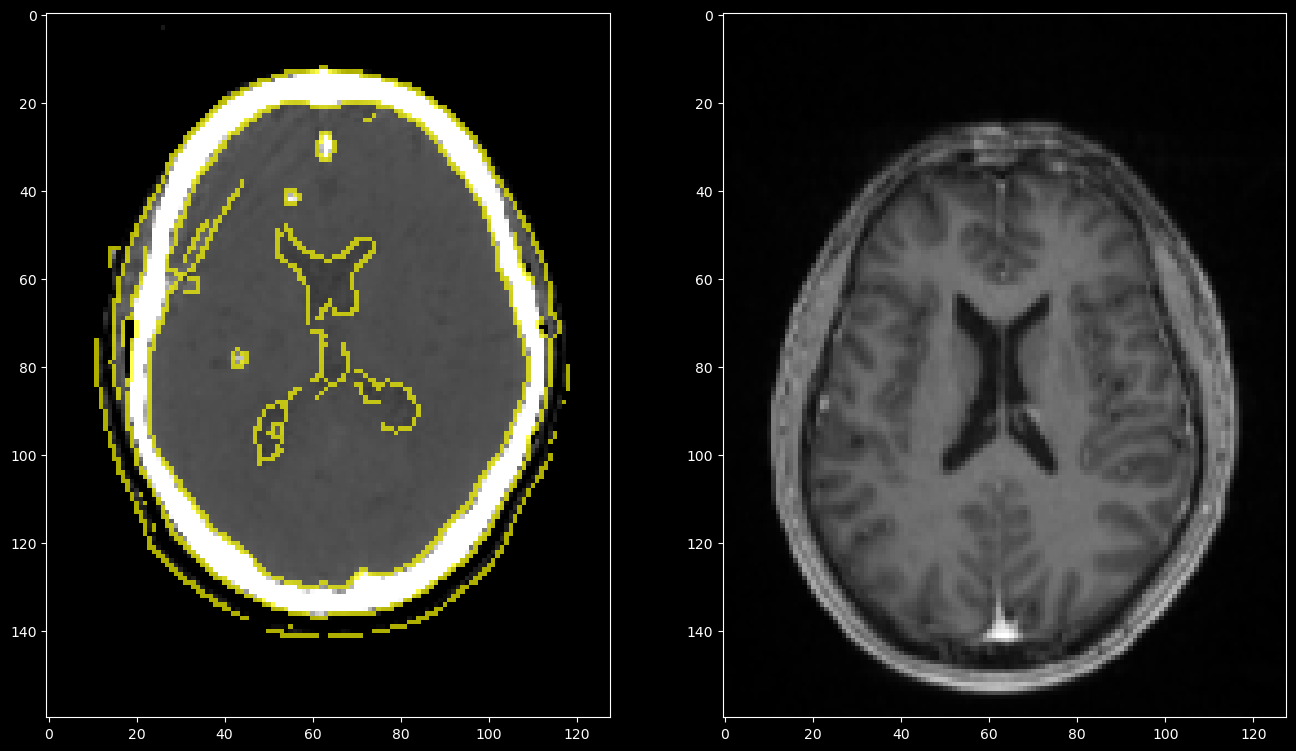

In [34]:
fig, ax = plt.subplots(1,2,figsize = (16,24))
# ax[0].imshow(np.flipud(cbct[:,:,70].T), cmap='gray', clim=np.percentile(cbct, (75,93)))
ax[0].imshow(np.flipud(cbct_i[:,:,60].T), cmap='gray', vmin = 0.2, vmax = 0.8)
ax[0].imshow(np.flipud(canny(cbct_i_can[:,:,60].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
ax[1].imshow(np.flipud(mr_i[:,:,76].T), cmap='gray',vmin = 0,vmax = 0.4)



In [35]:
norm_out_cbct = 'inputs_clnc1/N040/CBCT_resample_crop_norm.nii.gz'
norm_out_mrpre = 'inputs_clnc1/N040/MR_resample_crop_norm.nii.gz'
# norm_out_mrpost = 'inputs_clnc2/V016/Post_MR_resampled_crop_norm.nii.gz'

nib.Nifti1Image(cbct_i, cbct_n.affine,cbct_n.header).to_filename(norm_out_cbct)
nib.Nifti1Image(mr_i, mr_n.affine,mr_n.header).to_filename(norm_out_mrpre)

In [36]:
def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )
    
##fixed is cbct and moving is mr
def registration(fixed_src, moving_src, registered_dst):

    fixed = sitk.ReadImage(fixed_src, sitk.sitkFloat32)##ct
    moving = sitk.ReadImage(moving_src, sitk.sitkFloat32)
    min = sitk.GetArrayFromImage(moving).min()
    numberOfBins = 50
    samplingPercentage = 0.1

    tx = sitk.CenteredTransformInitializer(
        fixed, moving, sitk.Euler3DTransform(),sitk.CenteredTransformInitializerFilter.GEOMETRY)
    # sitk.WriteTransform(tx, "euler2D_initial.tfm")


    R = sitk.ImageRegistrationMethod()


    pixelType = sitk.sitkFloat32

    R.SetMetricAsCorrelation()

    R.SetOptimizerAsRegularStepGradientDescent(
        learningRate=1.0,
        minStep=0.001,
        numberOfIterations=1500,
        gradientMagnitudeTolerance=1e-8,
    )
    # R.SetOptimizerScalesFromIndexShift()
    R.SetOptimizerScalesFromPhysicalShift()

    R.SetInitialTransform(tx)



    ##some tricks
    R.SetMetricAsMattesMutualInformation(numberOfBins)
    R.SetShrinkFactorsPerLevel([4,2,1])
    R.SetSmoothingSigmasPerLevel( [4,2,1] )
    R.SetMetricSamplingPercentage(samplingPercentage, sitk.sitkWallClock)
    R.SetMetricSamplingStrategy(R.RANDOM)
    # R.SetOptimizerAsRegularStepGradientDescent(5.0, 0.001, 500)
    # R.SetInitialTransform(sitk.TranslationTransform(fixed.GetDimension()))
    R.SetInterpolator(sitk.sitkLinear)

    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

    outTx = R.Execute(fixed, moving)

    # print("-------")
    # print(outTx)
    # print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
    # print(f" Iteration: {R.GetOptimizerIteration()}")
    # print(f" Metric value: {R.GetMetricValue()}")

##  whether to save the transformation
#     sitk.WriteTransform(outTx, "euler2D.tfm")

    if "SITK_NOSHOW" not in os.environ:
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed)
        resampler.SetInterpolator(sitk.sitkLinear)
        # resampler.SetDefaultPixelValue(1)
        resampler.SetDefaultPixelValue(0)

        resampler.SetTransform(tx)

        out = resampler.Execute(moving)
        simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
        simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
        # simg1 = fixed
        # simg2 = out
        cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)
        # cimg = simg2


    ##whether to view the result
    #     image_viewer = sitk.ImageViewer()
    #     image_viewer.SetApplication('E://zli//workspace//Fiji.app//ImageJ-win64')
    #     image_viewer.SetTitle('MR image')
    #     image_viewer.Execute(cimg)

    ##cimg
    print(sitk.GetArrayFromImage(simg2).max())
    sitk.WriteImage(simg2,registered_dst)

    print(fixed.GetPixelIDValue())
    print(fixed.GetDimension())

In [37]:
rigid_mrpre = 'inputs_clnc1/N040/CBCT_resample_crop_norm_rigid.nii.gz'
registration(norm_out_cbct, norm_out_mrpre, rigid_mrpre)

  0 =   -0.41171 : (-0.0003322946549552449, 0.007018530954784176, 0.0013194216838235161, -140.57861404956913, -130.10347194163887, -75.68663233935446)
  1 =   -0.41564 : (-0.0009934512149861615, 0.006285872700279041, 0.0017816945480337873, -139.91638205431377, -129.4583008232789, -75.30557876716028)
  2 =   -0.41916 : (0.00017615529195828946, 0.008676084277177448, 0.001941673555564105, -140.37525745963876, -128.82250512960172, -74.68494192358321)
  3 =   -0.42178 : (-0.002054421054241034, 0.008263336108643073, 0.002990977297050671, -140.6179737483207, -129.55607109888692, -74.05014784276257)
  4 =   -0.42120 : (-0.0013658427297927257, 0.0069815503388337445, 0.0030389753420447373, -140.254126029041, -129.2131273488512, -74.05166509940221)
  5 =   -0.42350 : (-0.000701639687889719, 0.0067764784181266625, 0.002540931772493319, -140.53438620126525, -128.802309463082, -73.99987543509172)
  6 =   -0.42393 : (-0.0009279276117141229, 0.005935621219124349, 0.0030872056040676995, -140.4310070924

1.0 0.0
0.58625 0.0


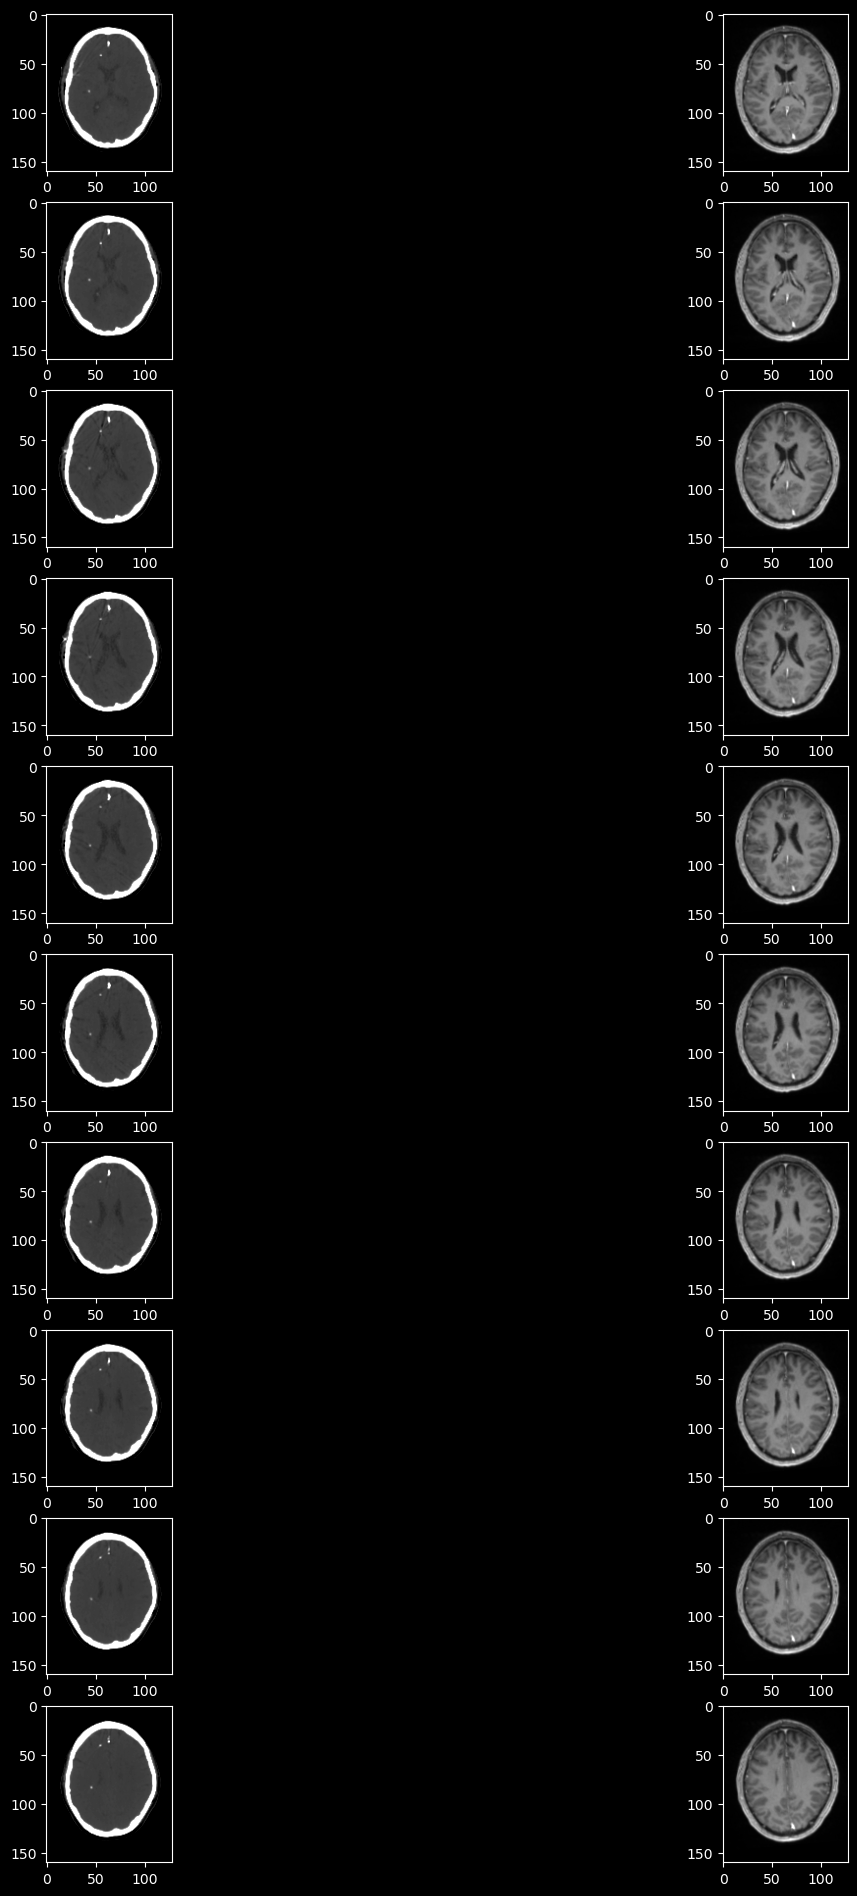

In [38]:
norm_out_cbct = 'inputs_clnc1/N040/CBCT_resample_crop_norm.nii.gz'
rigid_mrpre = 'inputs_clnc1/N040/CBCT_resample_crop_norm_rigid.nii.gz'

cbct = nib.load(norm_out_cbct).get_fdata()
print(cbct.max(),cbct.min())
mr = nib.load(rigid_mrpre).get_fdata()/255*mr_i.max()
print(mr.max(),mr.min())
islice = 60
fig, ax = plt.subplots(10,2,figsize = (16,24))
for i in range(10):
# ax[0].imshow(np.flipud(cbct[:,:,70].T), cmap='gray', clim=np.percentile(cbct, (75,93)))
    ax[i,0].imshow(np.flipud(cbct[:,:,islice+i].T), cmap='gray', vmin = 0.2, vmax = 0.95)
    ax[i,1].imshow(np.flipud(mr[:,:,islice+i].T), cmap='gray',vmin = 0, vmax = 0.4)

In [39]:
device = 'cpu'
G = networks_gan.JSRCascade(separate_decoders=True, res=True, version='v3').to(device)
checkpoint = torch.load('JSRCascade_l1100_multi0.3_reg100_seg0_ep109.pt', map_location=torch.device('cpu'))
G.load_state_dict(checkpoint['G_state_dict'])

<All keys matched successfully>

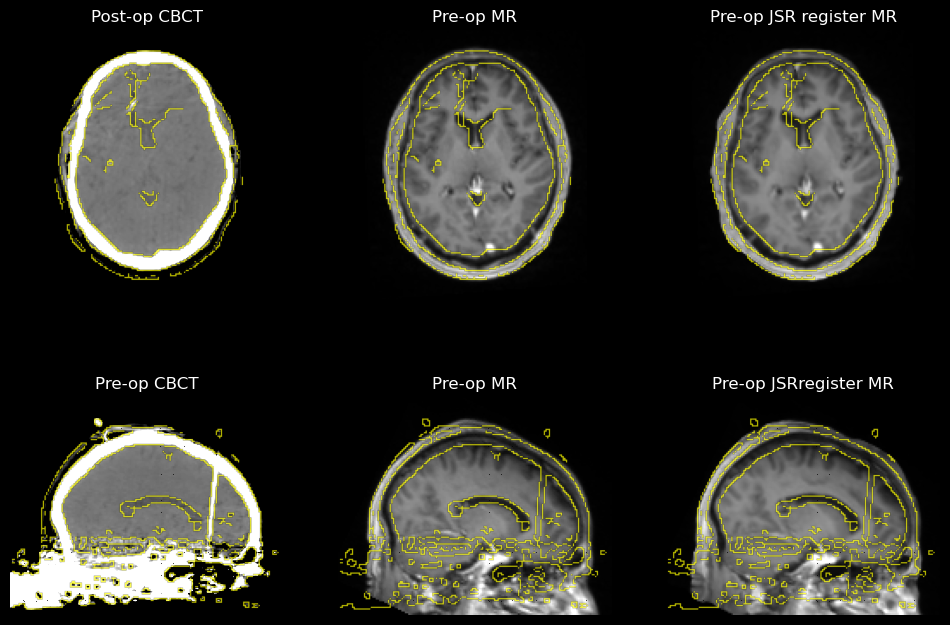

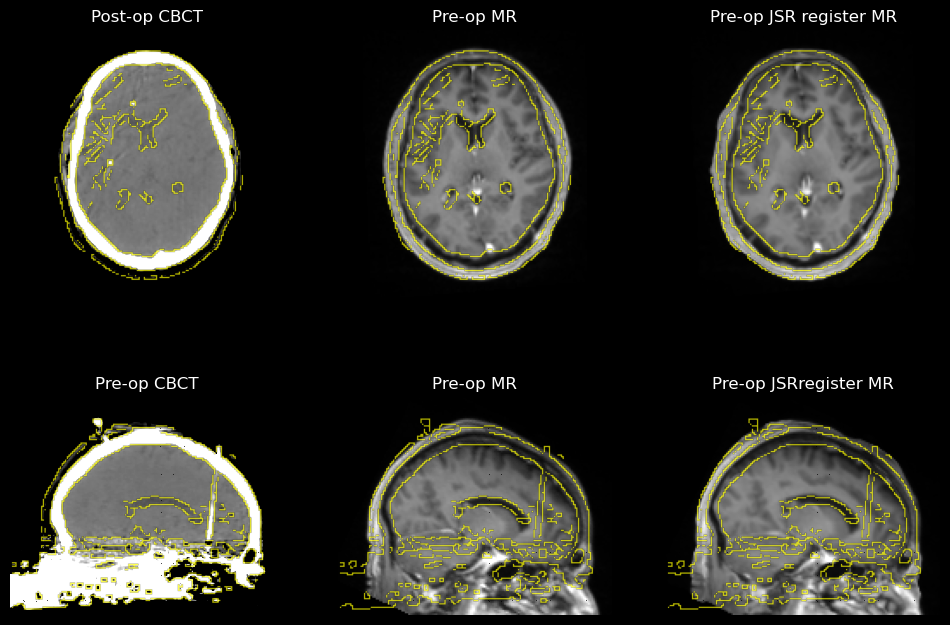

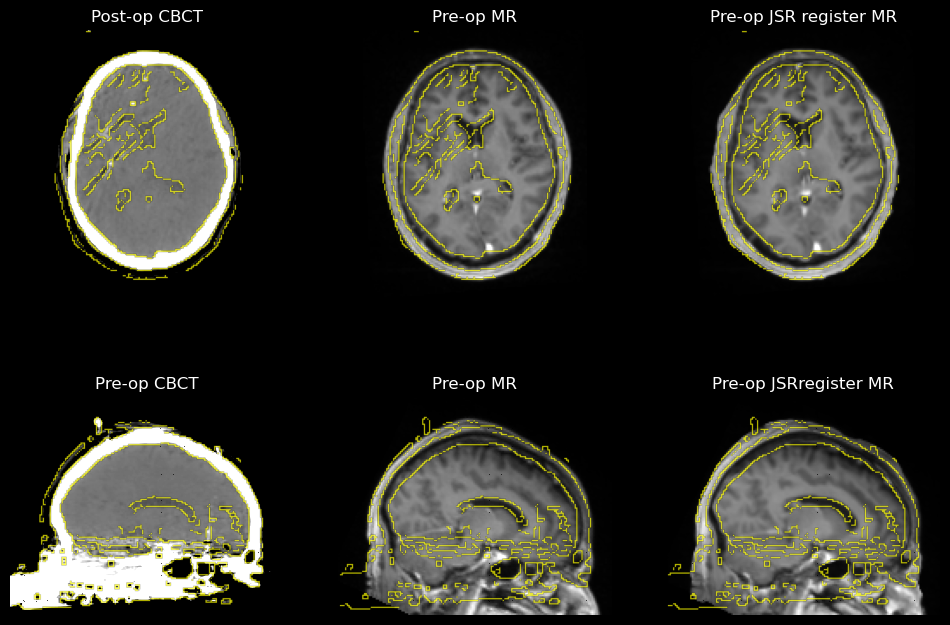

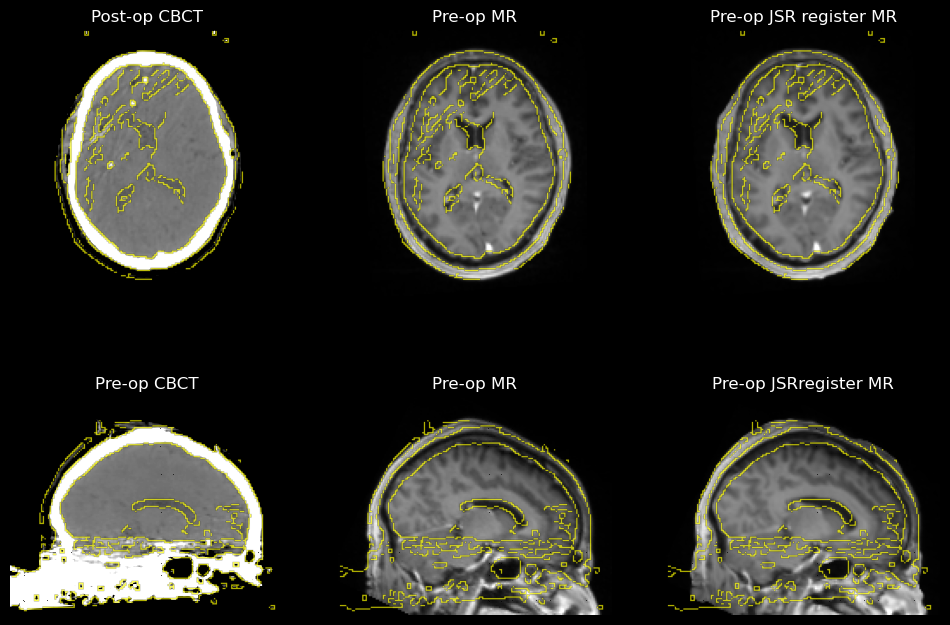

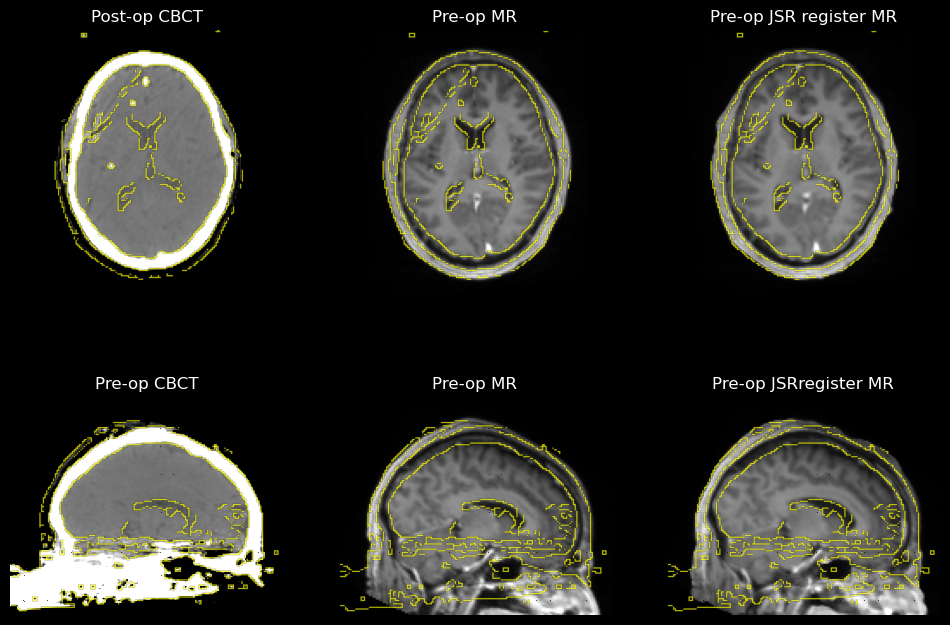

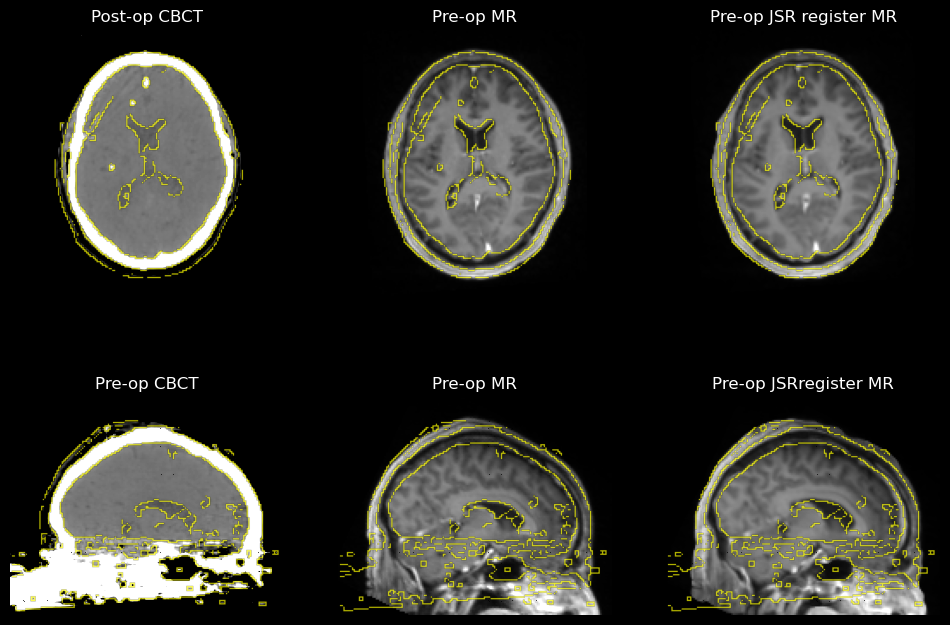

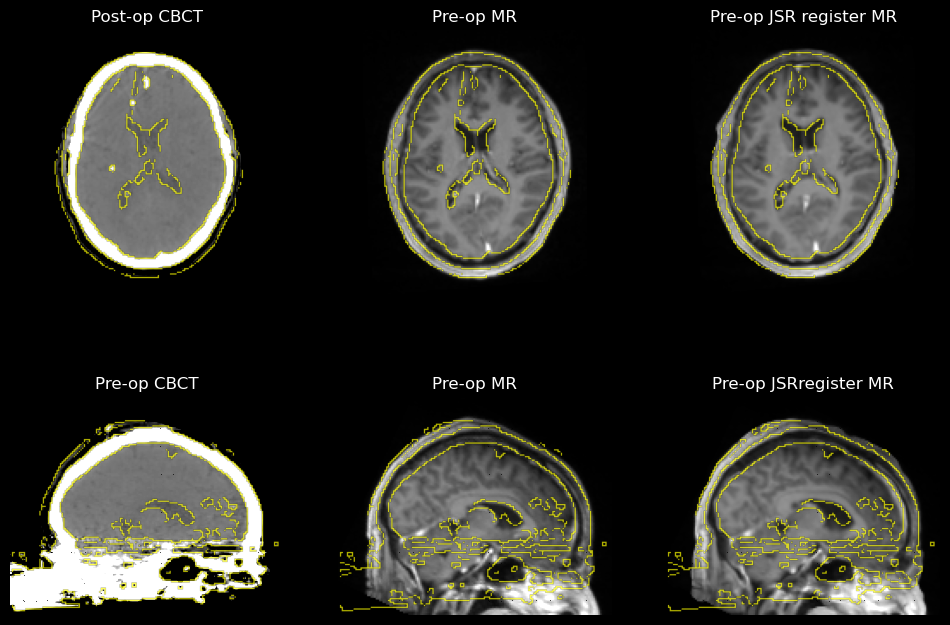

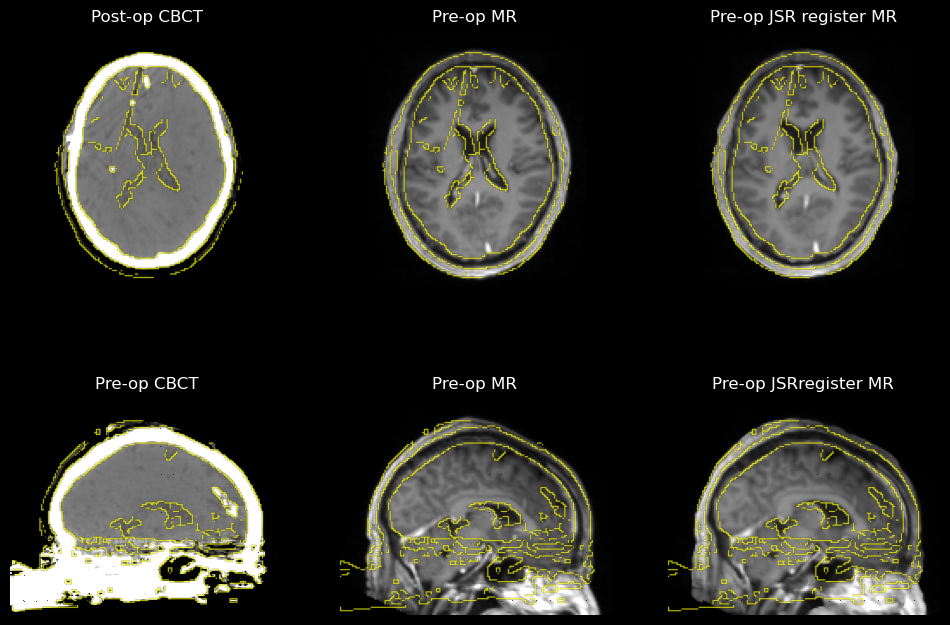

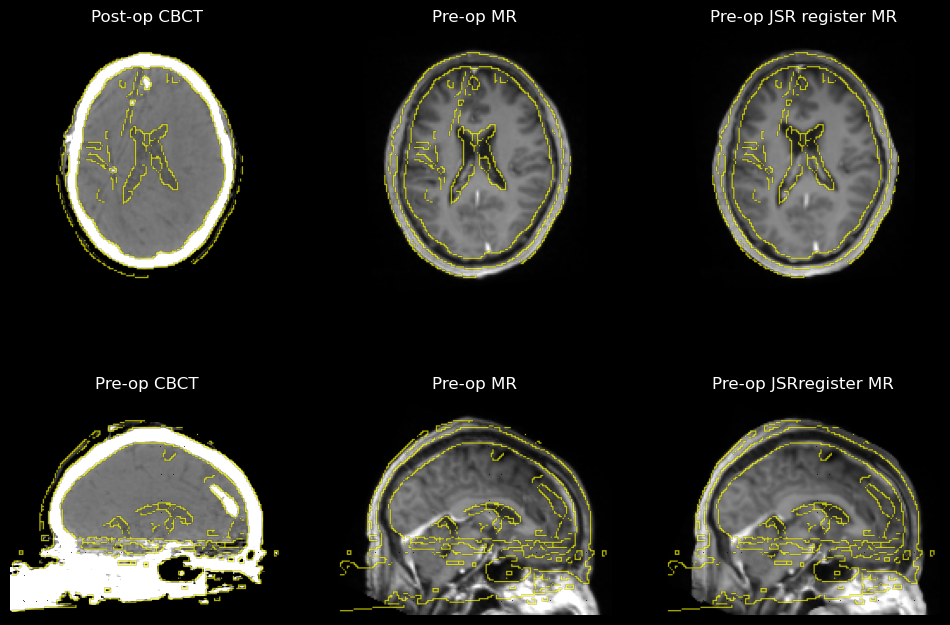

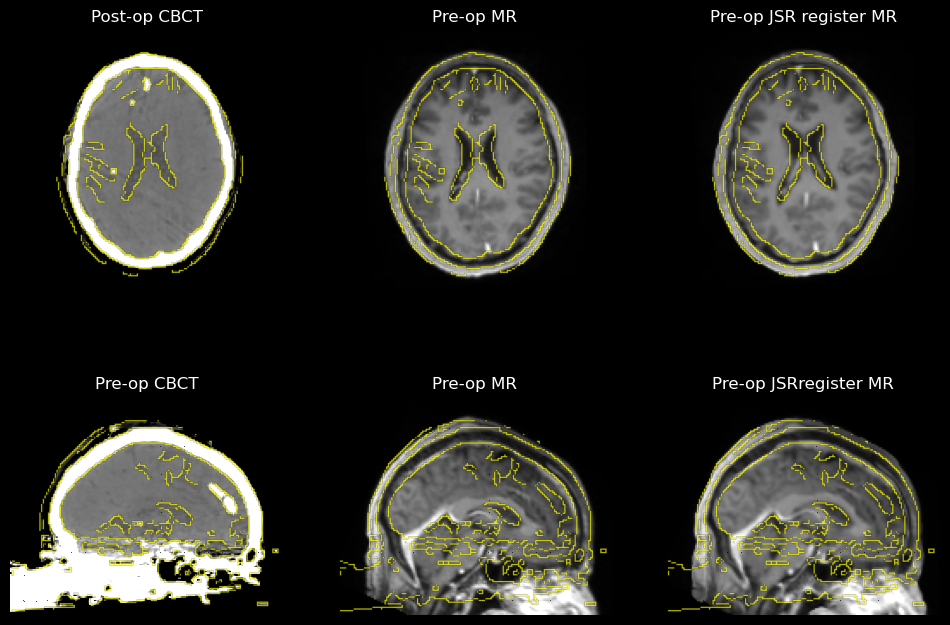

In [40]:
cbct_fixed = torch.from_numpy(cbct).float().unsqueeze(0).unsqueeze(0).to(device)
mr_moving = torch.from_numpy(mr).float().unsqueeze(0).unsqueeze(0).to(device)
# cbct_fixed = torch.from_numpy(cbct_i_can).float().unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    flow, ct_moving_synth, ct_fixed_synth= G(mr_moving, cbct_fixed)
    mr_reg = vxm.layers.SpatialTransformer([128,160,128], mode='bilinear').to(device)(mr_moving, flow[0])


for i in range(10):
    islice = 55+i
    fig, ax = plt.subplots(2,3,figsize=(12,8))
    np.vectorize(lambda ax: ax.axis('off'))(ax)

    ax[0, 0].imshow(torch.flipud(cbct_fixed[0,0,:,:,islice].T), cmap='gray', vmin=0.2, vmax=0.6)
    ax[0, 0].imshow(canny(np.flipud(cbct_i_can[:,:,islice].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
    ax[0, 0].set_title('Post-op CBCT')

    ax[0, 1].imshow(torch.flipud(mr_moving[0,0,:,:,islice].T), cmap='gray', vmin=0, vmax=0.4)
    ax[0, 1].imshow(canny(np.flipud(cbct_i_can[:,:,islice].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
    ax[0, 1].set_title('Pre-op MR')

    ax[0, 2].imshow(torch.flipud(mr_reg[0,0,:,:,islice].T), cmap='gray', vmin=0, vmax=0.4)
    ax[0, 2].imshow(canny(np.flipud(cbct_i_can[:,:,islice].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
    ax[0, 2].set_title('Pre-op JSR register MR')

    ax[1, 0].imshow(torch.flipud(cbct_fixed[0,0,islice,:,:].T), cmap='gray', vmin=0.2, vmax=0.6)
    ax[1, 0].imshow(canny(np.flipud(cbct_i_can[islice,:,:].T), sigma=1), cmap=colormap_binary('yellow', alpha=0.7))
    ax[1, 0].set_title('Pre-op CBCT')

    ax[1, 1].imshow(torch.flipud(mr_moving[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
    ax[1, 1].imshow(np.flipud(canny(cbct_i_can[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
    ax[1, 1].set_title('Pre-op MR')

    ax[1, 2].imshow(torch.flipud(mr_reg[0,0,islice,:,:].T), cmap='gray', vmin=0, vmax=0.4)
    ax[1, 2].imshow(np.flipud(canny(cbct_i_can[islice,:,:].T, sigma=1)), cmap=colormap_binary('yellow', alpha=0.7))
    ax[1, 2].set_title('Pre-op JSRregister MR')
    